# Task 3: Claim vs Reference vs Context Classification

This notebook implements a machine learning pipeline for classifying scientific tweets into three categories (with possible overlaps):
- Claim
- Context
- Reference

## Setup

Import required libraries and configure warnings

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect

## Data Loading and Analysis

Loading data...

Distribution of classes (with overlaps):
label_text
CLAIM      263
CONTEXT    251
REF        203
Name: count, dtype: int64

Mapping used: {'CLAIM': 0, 'CONTEXT': 1, 'REF': 2}


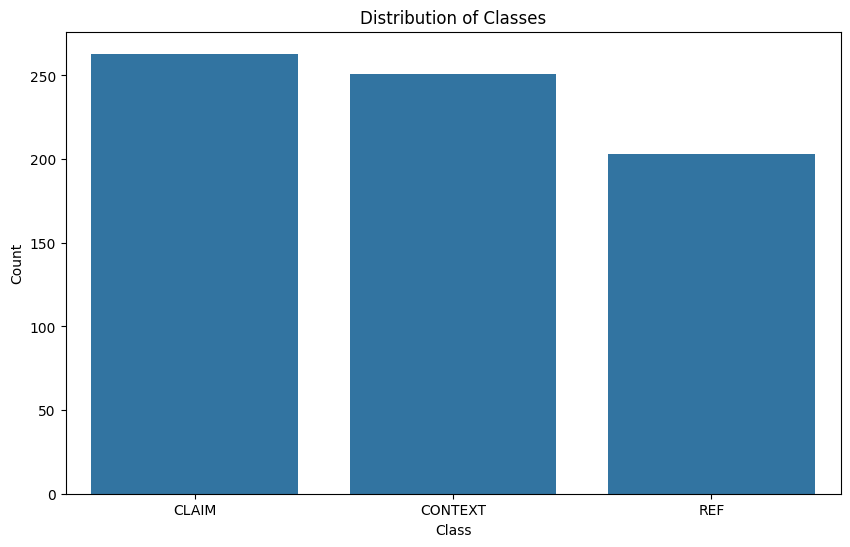

In [17]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Filter scientific tweets only
df_sci = df[df['science_related'] == 1].copy()

# Create separate groups with overlaps allowed
claim = df_sci[df_sci["scientific_claim"] == 1.0].copy()
claim["label_text"] = "CLAIM"

context = df_sci[df_sci["scientific_context"] == 1.0].copy()
context["label_text"] = "CONTEXT"

ref = df_sci[df_sci["scientific_reference"] == 1.0].copy()
ref["label_text"] = "REF"

# Combine all groups (allowing overlaps)
df_multi = pd.concat([claim, context, ref], ignore_index=True)

# Encode labels
label_map = {"CLAIM": 0, "CONTEXT": 1, "REF": 2}
df_multi["label"] = df_multi["label_text"].map(label_map)

# Display statistics
print("\nDistribution of classes (with overlaps):")
print(df_multi["label_text"].value_counts())
print("\nMapping used:", label_map)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_multi, x='label_text')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [18]:
# Feature analysis
df_multi['tweet_text'] = df_multi['text'].apply(lambda x: emoji.demojize(str(x)))

# Detect text features
df_multi['has_url'] = df_multi['text'].str.contains(r'http[s]?://', regex=True)
df_multi['has_mention'] = df_multi['text'].str.contains(r'@\w+', regex=True)
df_multi['has_hashtag'] = df_multi['text'].str.contains(r'#\w+', regex=True)
df_multi['has_emoji'] = df_multi['tweet_text'].str.contains(r':[^:\s]+:', regex=True)

# Count features by category
def count_by_category(col):
    return df_multi.groupby('label_text')[col].sum()

print("Feature distribution across classes:")
print("\nTweets with URL:")
display(count_by_category('has_url'))
print("\nTweets with Mention:")
display(count_by_category('has_mention'))
print("\nTweets with Hashtag:")
display(count_by_category('has_hashtag'))
print("\nTweets with Emoji:")
display(count_by_category('has_emoji'))

Feature distribution across classes:

Tweets with URL:


label_text
CLAIM      197
CONTEXT    236
REF        199
Name: has_url, dtype: int64


Tweets with Mention:


label_text
CLAIM      57
CONTEXT    73
REF        50
Name: has_mention, dtype: int64


Tweets with Hashtag:


label_text
CLAIM      76
CONTEXT    84
REF        65
Name: has_hashtag, dtype: int64


Tweets with Emoji:


label_text
CLAIM      5
CONTEXT    2
REF        2
Name: has_emoji, dtype: int64

## ModelPipeline Class Definition

Pipeline adapted for tweet classification

In [19]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score, average='weighted'),
            "Recall": make_scorer(recall_score, average='weighted'),
            "F1 Score": make_scorer(f1_score, average='weighted')
        }
        self.results = {}

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase"""
        # Convert emojis
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        # Add binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        if with_preprocessing:
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'
        else:
            text_column = 'text'

        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        """Prepare feature matrix with token categorization"""
        # TF-IDF Vectorization
        vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = vectorizer.fit_transform(X_text)
        
        # Categorize tokens
        feature_names = vectorizer.get_feature_names_out()
        token_categories = {token: self.get_token_category(token) for token in feature_names}
        
        # Binary features
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        
        # Combine features
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final, vectorizer
    
    @staticmethod
    def get_token_category(token):
        """Categorize token as numeric, timestamp, or valid"""
        if token.isdigit():
            return 'numeric'
        if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
            return 'timestamp'
        if re.match(r'^[a-zA-Z]+$', token):
            return 'valid'
        return 'other'

    def train_and_evaluate(self, X, y, phase_name):
        """Train and evaluate models using k-fold cross-validation"""
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            y_array = y.values
            
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y_array), 1):
                X_train = X[train_idx] if scipy.sparse.issparse(X) else X[train_idx]
                X_test = X[test_idx] if scipy.sparse.issparse(X) else X[test_idx]
                y_train = y_array[train_idx]
                y_test = y_array[test_idx]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
                fold_metrics["F1"].append(f1_score(y_test, y_pred, average='weighted'))
                
                if fold == cv.n_splits:
                    plt.figure(figsize=(8, 6))
                    cm = confusion_matrix(y_test, y_pred)
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})\nClaim vs Context vs Ref')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
                    
                    print("\nClassification Report:")
                    print(classification_report(y_test, y_pred, 
                                              target_names=['Claim', 'Context', 'Reference']))
            
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            
            results.append(metrics)
        
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_task3_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df

## Initialize Pipeline

In [20]:
# Initialize pipeline
pipeline = ModelPipeline()

## Phase 1: Without Preprocessing

Process and evaluate models using basic preprocessing

=== Phase 1: Without Preprocessing ===

🔍 Training model: Naïve Bayes


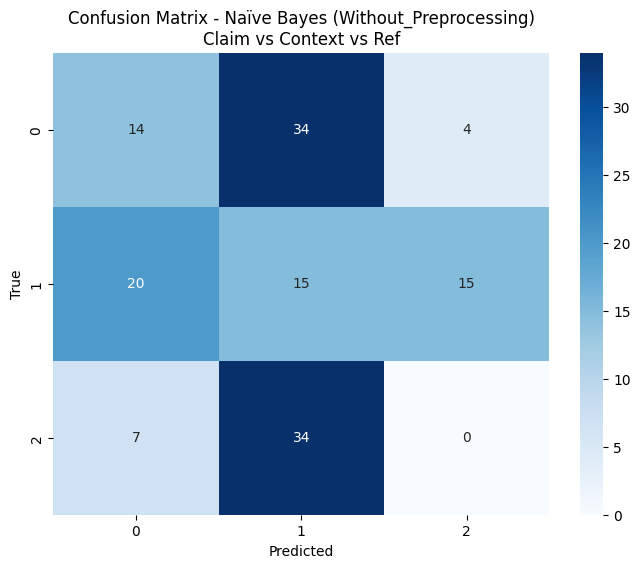


Classification Report:
              precision    recall  f1-score   support

       Claim       0.34      0.27      0.30        52
     Context       0.18      0.30      0.23        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.20       143
   macro avg       0.17      0.19      0.18       143
weighted avg       0.19      0.20      0.19       143

Accuracy: 0.2231 ± 0.0351
Precision: 0.2017 ± 0.0116
Recall: 0.2231 ± 0.0351
F1: 0.2072 ± 0.0224

🔍 Training model: Random Forest


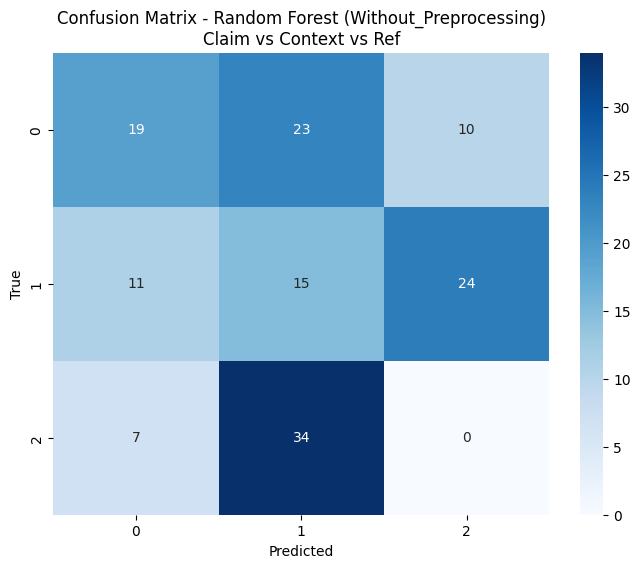


Classification Report:
              precision    recall  f1-score   support

       Claim       0.51      0.37      0.43        52
     Context       0.21      0.30      0.25        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.24       143
   macro avg       0.24      0.22      0.22       143
weighted avg       0.26      0.24      0.24       143

Accuracy: 0.2162 ± 0.0255
Precision: 0.2176 ± 0.0243
Recall: 0.2162 ± 0.0255
F1: 0.2143 ± 0.0200

🔍 Training model: SVM


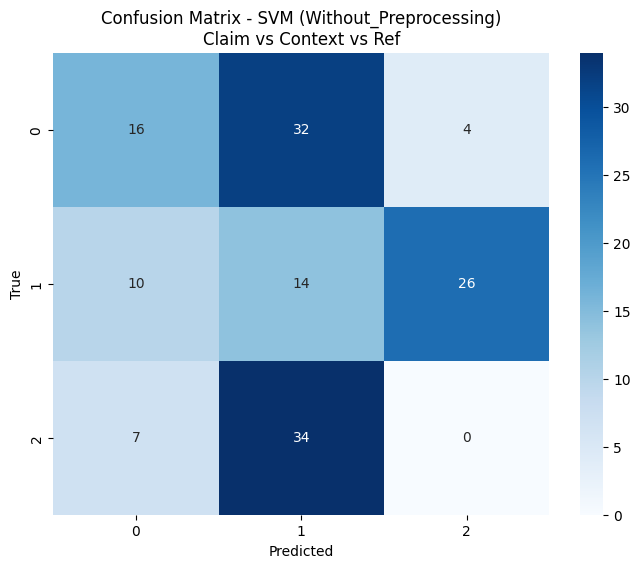


Classification Report:
              precision    recall  f1-score   support

       Claim       0.48      0.31      0.38        52
     Context       0.17      0.28      0.22        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.21       143
   macro avg       0.22      0.20      0.20       143
weighted avg       0.24      0.21      0.21       143

Accuracy: 0.2204 ± 0.0200
Precision: 0.2202 ± 0.0120
Recall: 0.2204 ± 0.0200
F1: 0.2153 ± 0.0105

🔍 Training model: KNN


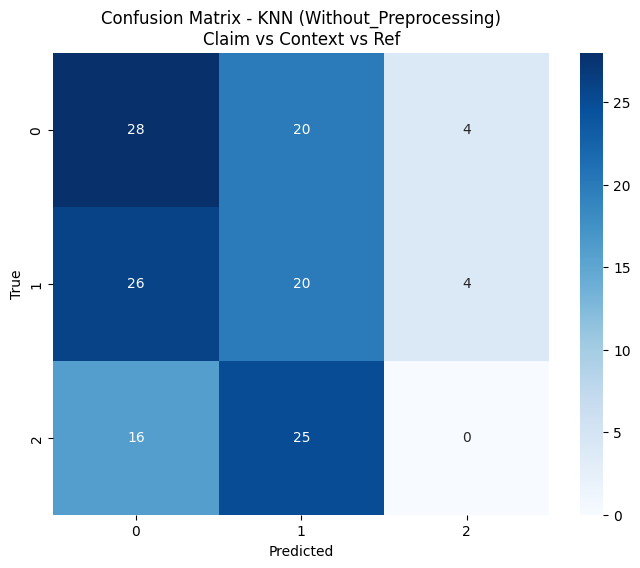


Classification Report:
              precision    recall  f1-score   support

       Claim       0.40      0.54      0.46        52
     Context       0.31      0.40      0.35        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.34       143
   macro avg       0.24      0.31      0.27       143
weighted avg       0.25      0.34      0.29       143

Accuracy: 0.3236 ± 0.0209
Precision: 0.2741 ± 0.0263
Recall: 0.3236 ± 0.0209
F1: 0.2853 ± 0.0168

🔍 Training model: AdaBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


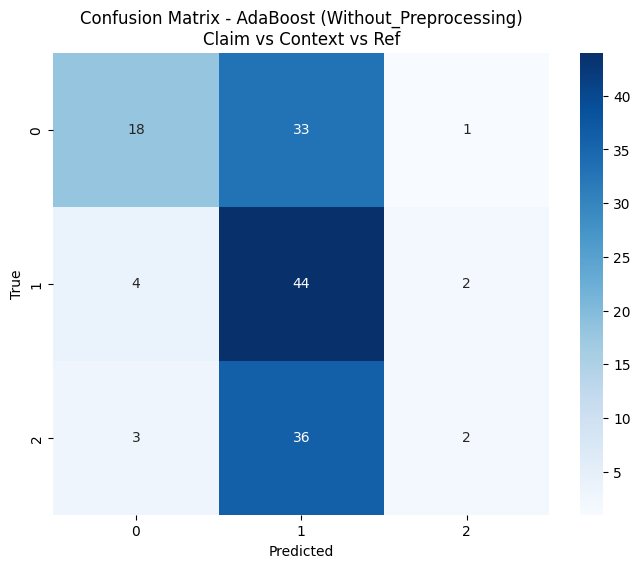

/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:31:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

       Claim       0.72      0.35      0.47        52
     Context       0.39      0.88      0.54        50
   Reference       0.40      0.05      0.09        41

    accuracy                           0.45       143
   macro avg       0.50      0.42      0.36       143
weighted avg       0.51      0.45      0.38       143

Accuracy: 0.4365 ± 0.0081
Precision: 0.4081 ± 0.0692
Recall: 0.4365 ± 0.0081
F1: 0.3704 ± 0.0138

🔍 Training model: XGBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:31:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_en

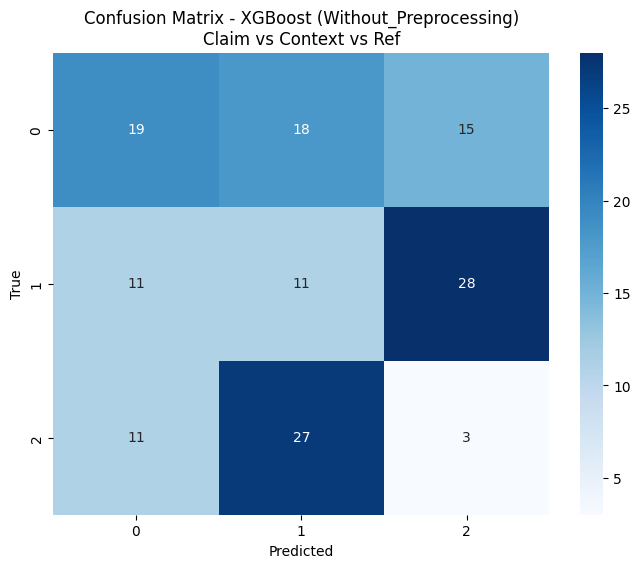


Classification Report:
              precision    recall  f1-score   support

       Claim       0.46      0.37      0.41        52
     Context       0.20      0.22      0.21        50
   Reference       0.07      0.07      0.07        41

    accuracy                           0.23       143
   macro avg       0.24      0.22      0.23       143
weighted avg       0.26      0.23      0.24       143

Accuracy: 0.2106 ± 0.0260
Precision: 0.2150 ± 0.0318
Recall: 0.2106 ± 0.0260
F1: 0.2110 ± 0.0253

🔍 Training model: Neural Network - MLP


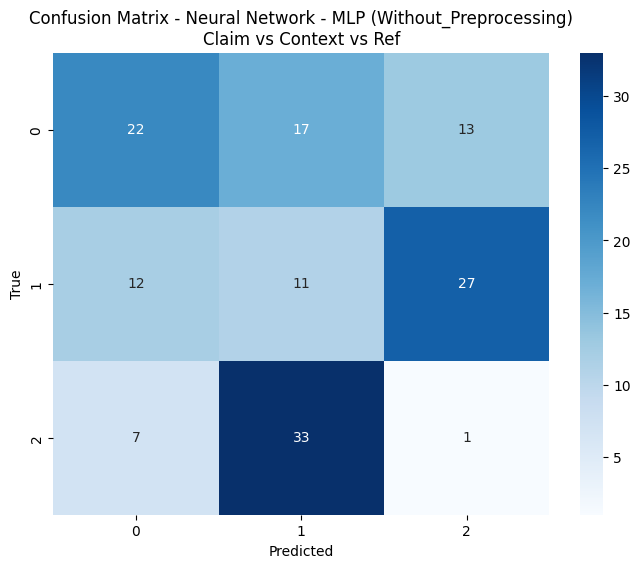


Classification Report:
              precision    recall  f1-score   support

       Claim       0.54      0.42      0.47        52
     Context       0.18      0.22      0.20        50
   Reference       0.02      0.02      0.02        41

    accuracy                           0.24       143
   macro avg       0.25      0.22      0.23       143
weighted avg       0.27      0.24      0.25       143

Accuracy: 0.2245 ± 0.0232
Precision: 0.2157 ± 0.0266
Recall: 0.2245 ± 0.0232
F1: 0.2185 ± 0.0198

Phase 1 Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Naïve Bayes,Without_Preprocessing,0.223096,0.035076,0.201692,0.011628,0.223096,0.035076,0.207246,0.022447
1,Random Forest,Without_Preprocessing,0.216162,0.025546,0.217586,0.024265,0.216162,0.025546,0.214295,0.020007
2,SVM,Without_Preprocessing,0.220367,0.020026,0.220244,0.011981,0.220367,0.020026,0.215309,0.010472
3,KNN,Without_Preprocessing,0.323631,0.020934,0.274128,0.026310,0.323631,0.020934,0.285323,0.016815
4,AdaBoost,Without_Preprocessing,0.436538,0.008096,0.408104,0.069162,0.436538,0.008096,0.370372,0.013762
5,XGBoost,Without_Preprocessing,0.210567,0.025980,0.214965,0.031824,0.210567,0.025980,0.211020,0.025308
6,Neural Network - MLP,Without_Preprocessing,0.224524,0.023213,0.215693,0.026554,0.224524,0.023213,0.218488,0.019811


In [22]:
print("=== Phase 1: Without Preprocessing ===")
df_phase1, text_column = pipeline.preprocess_data(df_multi.copy(), with_preprocessing=False)
X_phase1, _ = pipeline.prepare_features(df_phase1, text_column)
results_phase1 = pipeline.train_and_evaluate(X_phase1, df_multi['label'], "Without_Preprocessing")

print("\nPhase 1 Results:")
display(results_phase1)

## Phase 2: With Preprocessing

Process and evaluate models using advanced preprocessing techniques

=== Phase 2: With Preprocessing ===

🔍 Training model: Naïve Bayes


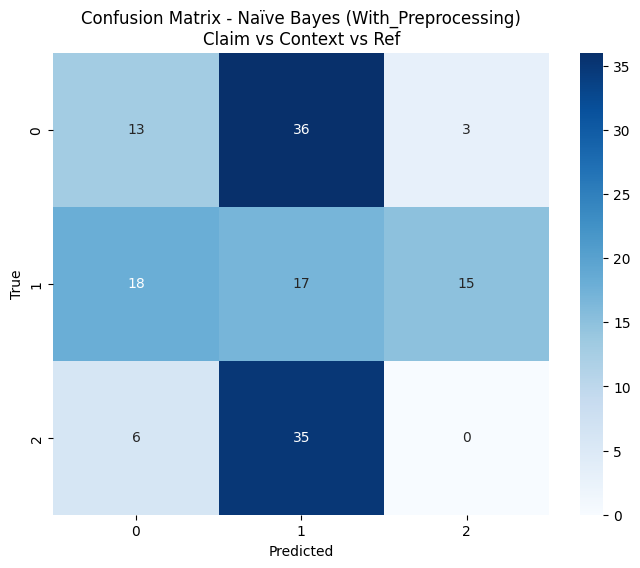


Classification Report:
              precision    recall  f1-score   support

       Claim       0.35      0.25      0.29        52
     Context       0.19      0.34      0.25        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.21       143
   macro avg       0.18      0.20      0.18       143
weighted avg       0.20      0.21      0.19       143

Accuracy: 0.2217 ± 0.0323
Precision: 0.2002 ± 0.0085
Recall: 0.2217 ± 0.0323
F1: 0.2042 ± 0.0213

🔍 Training model: Random Forest


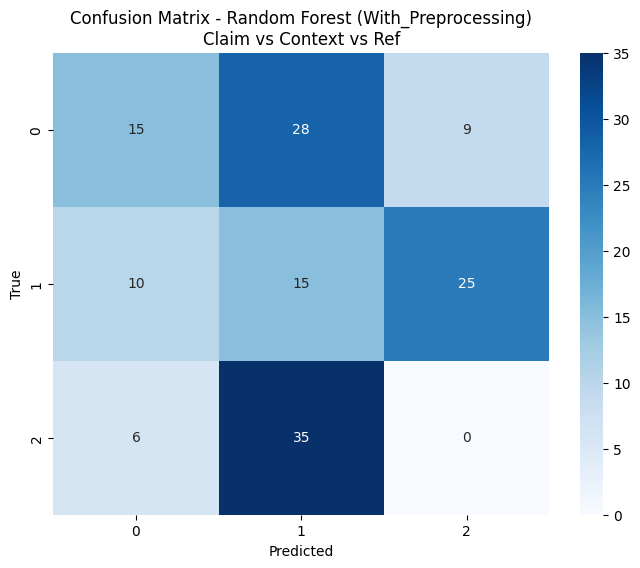


Classification Report:
              precision    recall  f1-score   support

       Claim       0.48      0.29      0.36        52
     Context       0.19      0.30      0.23        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.21       143
   macro avg       0.23      0.20      0.20       143
weighted avg       0.24      0.21      0.21       143

Accuracy: 0.2008 ± 0.0252
Precision: 0.2152 ± 0.0244
Recall: 0.2008 ± 0.0252
F1: 0.2021 ± 0.0222

🔍 Training model: SVM


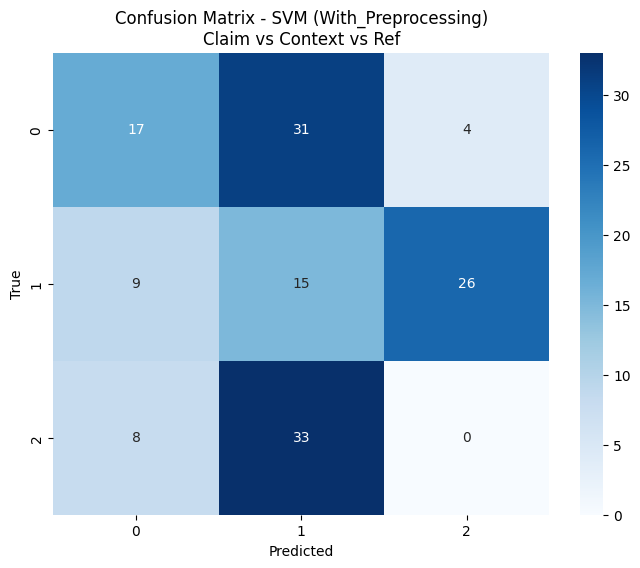


Classification Report:
              precision    recall  f1-score   support

       Claim       0.50      0.33      0.40        52
     Context       0.19      0.30      0.23        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.22       143
   macro avg       0.23      0.21      0.21       143
weighted avg       0.25      0.22      0.23       143

Accuracy: 0.2162 ± 0.0120
Precision: 0.2163 ± 0.0221
Recall: 0.2162 ± 0.0120
F1: 0.2108 ± 0.0110

🔍 Training model: KNN


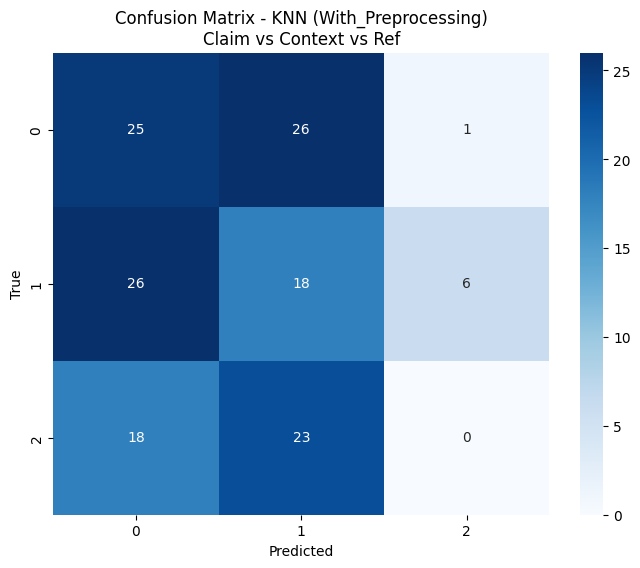


Classification Report:
              precision    recall  f1-score   support

       Claim       0.36      0.48      0.41        52
     Context       0.27      0.36      0.31        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.30       143
   macro avg       0.21      0.28      0.24       143
weighted avg       0.23      0.30      0.26       143

Accuracy: 0.3165 ± 0.0227
Precision: 0.2604 ± 0.0292
Recall: 0.3165 ± 0.0227
F1: 0.2795 ± 0.0258

🔍 Training model: AdaBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


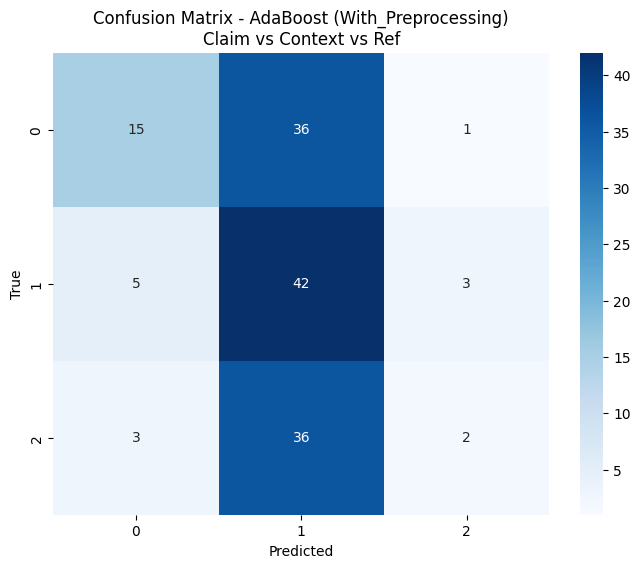


Classification Report:
              precision    recall  f1-score   support

       Claim       0.65      0.29      0.40        52
     Context       0.37      0.84      0.51        50
   Reference       0.33      0.05      0.09        41

    accuracy                           0.41       143
   macro avg       0.45      0.39      0.33       143
weighted avg       0.46      0.41      0.35       143

Accuracy: 0.4141 ± 0.0378
Precision: 0.3827 ± 0.0469
Recall: 0.4141 ± 0.0378
F1: 0.3521 ± 0.0309

🔍 Training model: XGBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_en

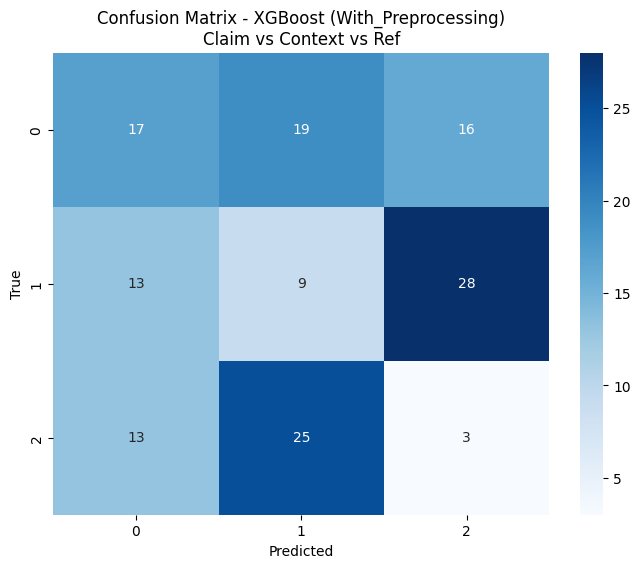


Classification Report:
              precision    recall  f1-score   support

       Claim       0.40      0.33      0.36        52
     Context       0.17      0.18      0.17        50
   Reference       0.06      0.07      0.07        41

    accuracy                           0.20       143
   macro avg       0.21      0.19      0.20       143
weighted avg       0.22      0.20      0.21       143

Accuracy: 0.1980 ± 0.0220
Precision: 0.2143 ± 0.0197
Recall: 0.1980 ± 0.0220
F1: 0.2030 ± 0.0178

🔍 Training model: Neural Network - MLP


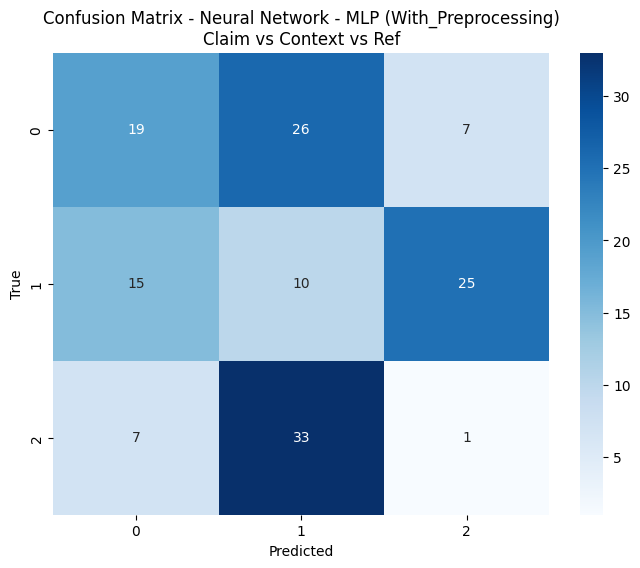


Classification Report:
              precision    recall  f1-score   support

       Claim       0.46      0.37      0.41        52
     Context       0.14      0.20      0.17        50
   Reference       0.03      0.02      0.03        41

    accuracy                           0.21       143
   macro avg       0.21      0.20      0.20       143
weighted avg       0.23      0.21      0.22       143

Accuracy: 0.2078 ± 0.0201
Precision: 0.2147 ± 0.0145
Recall: 0.2078 ± 0.0201
F1: 0.2098 ± 0.0140

Phase 2 Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Naïve Bayes,With_Preprocessing,0.221698,0.032314,0.200156,0.008522,0.221698,0.032314,0.204163,0.021350
1,Random Forest,With_Preprocessing,0.200806,0.025228,0.215196,0.024443,0.200806,0.025228,0.202123,0.022172
2,SVM,With_Preprocessing,0.216152,0.011991,0.216286,0.022123,0.216152,0.011991,0.210772,0.010973
3,KNN,With_Preprocessing,0.316540,0.022729,0.260437,0.029201,0.316540,0.022729,0.279453,0.025841
4,AdaBoost,With_Preprocessing,0.414112,0.037832,0.382742,0.046932,0.414112,0.037832,0.352092,0.030899
5,XGBoost,With_Preprocessing,0.198009,0.021959,0.214299,0.019724,0.198009,0.021959,0.202995,0.017836
6,Neural Network - MLP,With_Preprocessing,0.207789,0.020117,0.214650,0.014481,0.207789,0.020117,0.209756,0.014048


In [24]:
print("=== Phase 2: With Preprocessing ===")
df_phase2, text_column = pipeline.preprocess_data(df_multi.copy(), with_preprocessing=True)

# Load French stopwords
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

X_phase2, _ = pipeline.prepare_features(df_phase2, text_column, french_stopwords)
results_phase2 = pipeline.train_and_evaluate(X_phase2, df_multi['label'], "With_Preprocessing")

print("\nPhase 2 Results:")
display(results_phase2)

## Results Comparison

Compare the results between both phases

In [ ]:
# Combine results
all_results = pd.concat([results_phase1, results_phase2])

# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=all_results, x='Phase', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    if i > 1:  # Only show legend for the first subplot
        plt.legend([])
    
plt.tight_layout()
plt.show()